In [1]:
from utils import *
import math
import h5py
from tqdm import tqdm
from sklearn.utils import shuffle

# Problem Statement and Setup
We will be focusing on the Hep G2 cells in the dataset to limit the scope of our project. Depending on our progress, we have a path to extend the project by incorporating other cell types as well.

### Tasks:
1. Separate HEPG2 experiments based t-SNE plots (2 test, 5train).
2. Create a baseline method for siRNA classification.
3. Train model on HEPG2 data.
4. Create denoising procedures. 
5. Train model on denoised data.
6. Compare $\Delta$accuracy. 

#### Train, test splits

Observing the t-SNE plots from previous notebook, we will use HEPG2-02 and HEPG2-04 as our test set. The reasoning behind is, we want our test sets to not be similar to each other as well as from our train sets.

In [6]:
splits = {'train': ['HEPG2-01', 'HEPG2-03', 'HEPG2-05', 'HEPG2-06'], 
          'val': ['HEPG2-07'], 
          'test': ['HEPG2-02', 'HEPG2-04']}

1 input --> vae --> compare to k other experiments and itself

In [4]:
def nCk(n, k):
    return math.factorial(n) // math.factorial(k) // math.factorial(n - k)

In [5]:
train_experiment_count = 5
total_experiment_count = 7
plates_per_experiment = 4
k = 2
sites_per_well = 2
images_per_site = 4
channels_per_image = 6
res = 256
# n_train = (control_sirna_count * train_experiment_count * plates_per_experiment * images_per_well #choose input
#            * nCk(train_experiment_count-1, k) * plates_per_experiment**k * images_per_well)
# print('{:,} unique training examples'.format(n_train))

In [27]:
controls_df = {}
df = pd.read_csv(os.path.join(RECURSION_TRAIN_DIR, 'train_controls.csv'))
df['cell_line'] = [v[0] for v in df.id_code.str.split('-')]
df = df[df['cell_line'] == 'HEPG2']
df = df[df['well_type'] == 'positive_control']
missing_sirna = list(set(df.sirna).difference(set(df.query('experiment == "HEPG2-07" and plate == 2').sirna.values)))
df = df.query('sirna not in @missing_sirna')
df = df.sort_values(by=['experiment', 'plate', 'sirna'])
sirnas = df.sirna.unique()
for split, experiments in splits.items():
    controls_df[split] = df.query('experiment in @experiments')
    controls_df[split] = controls_df[split].reset_index(drop=True)

In [63]:
sirnas.sort()

In [65]:
sirnas_lookup = {sirna: ix for ix, sirna in enumerate(sirnas)}

In [60]:
inv_splits = {split: {exp: ix for ix, exp in enumerate(splits[split])} for split in splits}

In [72]:
images = {}
for split in splits:
    images[split] = np.zeros((len(splits[split]), 4, len(sirnas), 2, 512, 512, 6), dtype=np.float32)
    for i, x in controls_df[split].iterrows():
        for site in range(2):
            for ch in range(6):
                path = get_image_path(x.experiment, x.plate, x.well, site+1, ch+1, True)
                img = read_image(path)
                images[split][inv_splits[split][x.experiment], x.plate-1, sirnas_lookup[x.sirna], site, :, :, ch] = img       

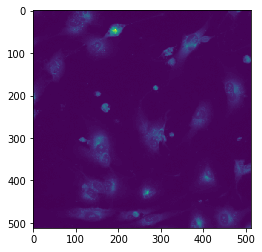

In [75]:
plt.imshow(images['train'][2, 3, 15, 1, :, :, 3])

In [82]:
controls_df['train'].query('experiment == "HEPG2-05" & plate==4 & sirna==1124')

,id_code,experiment,plate,well,sirna,well_type,cell_line
334,HEPG2-05_4_J11,HEPG2-05,4,J11,1124,positive_control,HEPG2


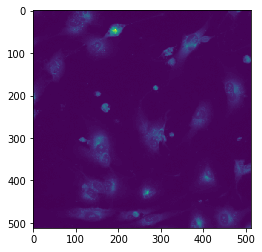

In [86]:
x = read_image(get_image_path('HEPG2-05', 4, 'J11', 2, 4, True))
plt.imshow(x)

### Exporting to npy files

In [95]:
for split in splits:
    save_dir = os.path.join(RECURSION_DIR, 'npy', 'controls', split)
    filename = 'controls-{}-f32.npy'.format(split)
    path = os.path.join(save_dir, filename)
    np.save(path, images[split])